In [2]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

In [4]:
with open('data/pv.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [7]:
x_scaler = MinMaxScaler()
x_scaler.fit(pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']])
pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']] = x_scaler.transform(pv[['alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']])

In [8]:
pv = pv.set_index('datetime')

In [9]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,11,30,23,tzinfo=tz)]
pv_val = pv.loc[datetime(2006,11,30,00,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,20,00,tzinfo=tz):datetime(2006,12,31,23,tzinfo=tz)]

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [10]:
from torch.utils.data import DataLoader, Dataset

In [11]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, data_comp, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]
            # print(X.shape)

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]
            # print(Y.shape)

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y = Y.reshape(Y.shape[0], Y.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, 1=power)

        if data_comp==1:
            # Y = Y[:,:,0][:,:,None]
            print(Y.shape)

        if data_comp==2:
            X = Y[:,:,1:].copy()
            Y = Y[:,:,0][:,:,None]
            print(X.shape)
            print(Y.shape)
        
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

# model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.auto import tqdm
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
class lstm(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1): # num_layers: lstm layer 수
        super(lstm, self).__init__() 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # batch_first=True 인 경우 (batch, input_window, feature) 에 맞춰서 input
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, bidirectional=True) 
        self.linear = nn.Linear(self.hidden_size*2, 1)

    def forward(self, x):
        output, hidden = self.lstm(x)
        out = self.linear(output)
        return out

# Train

In [14]:
def train(model, train_loader, optimizer, criterion, device='cuda'):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.to(device).float()
        y = y.to(device).float()

        output = model(x).to(device)

        # print(f"x shape: {x.shape}")
        # print(f"y shape: {y.shape}")
        # print(f"pred shape: {output.shape}")
        # print(f"final y shape: {y[:,:,0].shape}")
        # print(f"final pred shape: {output[:,:,0].shape}")

        loss = criterion(output[:,:,0], y[:,:,0])
        loss.backward()
        optimizer.step()
        total_loss += loss.cpu().item()

    train_loss = total_loss/len(train_loader)
    
    return output.detach().cpu().numpy(), y.detach().cpu().numpy(), train_loss

def predict(model, test_loader, criterion, device='cuda', file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []

    for t, (x, y) in enumerate(test_loader):
        # print(t)
        x = x.to(device).float()
        y = y.to(device).float()

        with torch.no_grad():
            output = model(x).to(device)
        # print(output.shape)
        # outputs[t,:,:,:] = output
        outputs.append(list(output.detach().cpu().numpy()))
        ys.append(list(y.detach().cpu().numpy()))
        loss = criterion(output[:,:,0], y[:,:,0])
        total_loss += loss.cpu().item()

    test_loss = total_loss/len(test_loader)

    if file_name:
        torch.save(model.state_dict(), file_name)

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), test_loss

In [17]:
iw = 24
ow = 24
num_feature = 8

train_dataset = windowDataset(pv_train[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                              input_window=iw, output_window=ow, num_feature=num_feature, data_comp=2, stride=ow)
valid_dataset = windowDataset(pv_val[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=2, stride=ow)
test_dataset = windowDataset(pv_test[['power_scale', 'alt', 'azi', 'temp', 'dwpt', 'rhum', 'wspd', 'pres']], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=2, stride=ow)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

(333, 24, 7)
(333, 24, 1)
(20, 24, 7)
(20, 24, 1)
(11, 24, 7)
(11, 24, 1)


In [18]:
a = next(iter(train_loader))
print(a[0].shape)
print(a[1].shape)

torch.Size([64, 24, 7])
torch.Size([64, 24, 1])


In [33]:
param_config = {
    "learning_rate": 0.001,
    "epochs": 1000,
    "input_size": 7,
    "hidden_size": 20
}

In [34]:
device='cuda'
model = lstm(input_size=param_config['input_size'], hidden_size=param_config['hidden_size']).to(device)

learning_rate=param_config['learning_rate']
epoch = param_config['epochs']
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [35]:
# 파라미터 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,681 trainable parameters


In [36]:
# wandb.watch(model, log='all', log_freq=10)

val_loss_min = 100
file_name = 'model/basic.model'

pbar = tqdm(range(param_config['epochs']))
for epoch in pbar:
    *result_train, train_loss = train(model, train_loader, optimizer, criterion, device=device)
    *result_val, val_loss = predict(model, val_loader, criterion, device=device)
    *result_test, test_loss = predict(model, test_loader, criterion, device=device)

    if val_loss < val_loss_min:
        val_loss_min = val_loss
        torch.save(model.state_dict(), file_name)
        print(f"epoch: {epoch} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

    # wandb.log({"train_loss": train_loss, "val_loss": val_loss, "test_loss": test_loss, "val_loss_min": val_loss_min})

    pbar.set_postfix(loss=f"train_loss: {train_loss:.5f} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0 / val_loss: 0.10436 / test_loss: 0.04641
epoch: 1 / val_loss: 0.07957 / test_loss: 0.03969
epoch: 2 / val_loss: 0.07293 / test_loss: 0.05086
epoch: 5 / val_loss: 0.06893 / test_loss: 0.05170
epoch: 6 / val_loss: 0.06643 / test_loss: 0.04552
epoch: 7 / val_loss: 0.06451 / test_loss: 0.04358
epoch: 8 / val_loss: 0.06262 / test_loss: 0.04496
epoch: 9 / val_loss: 0.06101 / test_loss: 0.04712
epoch: 10 / val_loss: 0.05888 / test_loss: 0.04699
epoch: 11 / val_loss: 0.05552 / test_loss: 0.04234
epoch: 12 / val_loss: 0.05315 / test_loss: 0.04247
epoch: 13 / val_loss: 0.05082 / test_loss: 0.04234
epoch: 14 / val_loss: 0.04772 / test_loss: 0.03975
epoch: 15 / val_loss: 0.04515 / test_loss: 0.03871
epoch: 16 / val_loss: 0.04170 / test_loss: 0.03531
epoch: 17 / val_loss: 0.03865 / test_loss: 0.03290
epoch: 18 / val_loss: 0.03586 / test_loss: 0.02872
epoch: 19 / val_loss: 0.03442 / test_loss: 0.03205
epoch: 20 / val_loss: 0.03332 / test_loss: 0.02707
epoch: 21 / val_loss: 0.03180 / test_lo

In [37]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,:,0].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,:,0].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

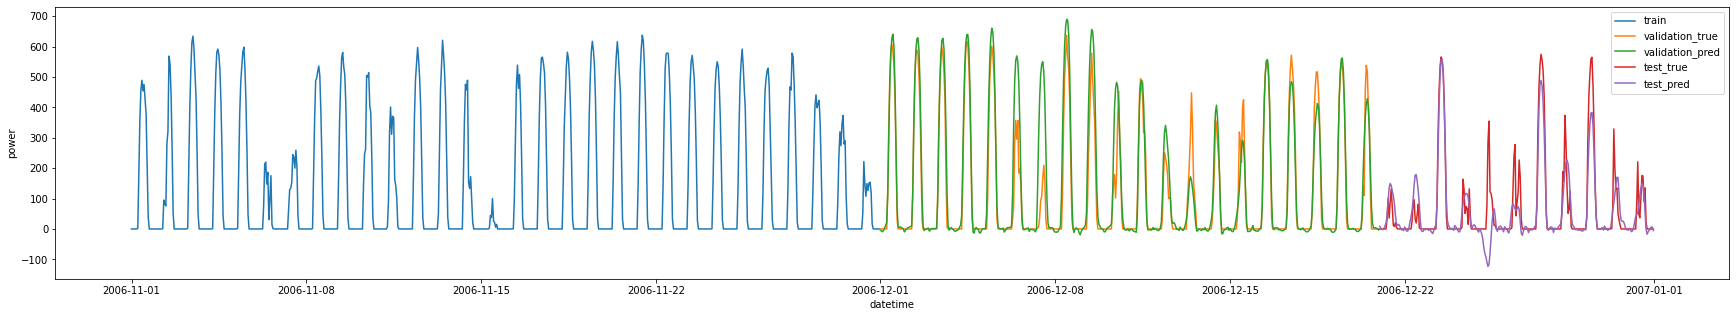

In [38]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'], label='validation_true')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pred_val.reshape(-1), label='validation_pred')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]['power'], label='test_true')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pred_test.reshape(-1), label='test_pred')
plt.legend()

In [39]:
model.load_state_dict(torch.load(file_name))
*result_val, val_loss = predict(model, val_loader, criterion, device='cuda')
*result_test, test_loss = predict(model, test_loader, criterion, device='cuda')

In [40]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,:,0].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,:,0].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

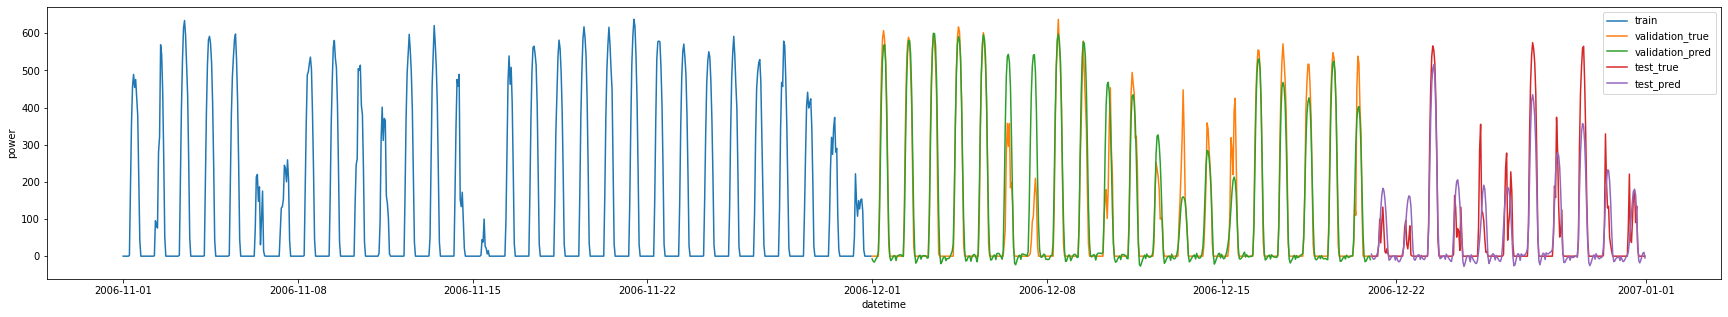

In [41]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'], label='validation_true')
sns.lineplot(pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pred_val.reshape(-1), label='validation_pred')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]['power'], label='test_true')
sns.lineplot(pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):].index, pred_test.reshape(-1), label='test_pred')
plt.legend()